# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 3 - Forecasting Bike Sharing Usage


<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Classroom.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
from IPython.core.display import HTML
def css_styling():
    styles = open("style/cs109.css", "r").read()
    return HTML(styles)
css_styling()

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. You will prepare a small report for them.

The hourly demand information would be useful in planning the number of bikes that need to be available in the system on any given hour of the day, and also in monitoring traffic in the city. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on attributes about the hour and the day. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will add some features that will help us with the analysis and then separate it into training and test sets. Each row in this file contains 12 attributes and each entry represents one hour of a 24-hour day with its weather, etc, and the number of rental rides for that day divided in categories according to if they were made by registered or casual riders. Those attributes are the following:

- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Explore how Bike Ridership varies with Hour of the Day </b> </div>

#### Learn your Domain and Perform a bit of Feature Engineering

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011 and 1 for 2012.
- `month` with 1 through 12, with 1 denoting Jan. 
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

**1.4** Use visualization to inspect and comment on how **casual** rentals and **registered** rentals vary with the `hour`. 

**1.5** Use the variable `holiday` to show how **holidays** affect the relationship in question 1.4.  What do you observe? 

**1.6** Use visualization to show how **weather** affects **casual** and **registered** rentals. What do you observe? 

### Answers

#### 1.1 Load the dataset from the csv file  ...

In [3]:
# your code here

bikes_df = pd.read_csv('data/BSS_hour_raw.csv', parse_dates=['dteday'])
bikes_df.sample(5)

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
5915,2011-09-09,3,0,0,5,1,3,0.64,0.5606,0.94,0.1940,1,15
3956,2011-06-18,2,18,0,6,0,2,0.74,0.6818,0.55,0.1940,118,263
7313,2011-11-06,4,8,0,0,0,2,0.28,0.3030,0.87,0.0896,19,71
9722,2012-02-15,1,1,0,3,1,1,0.34,0.3636,0.53,0.0000,0,5
2815,2011-05-02,2,5,0,1,1,2,0.44,0.4394,0.77,0.1343,4,16


In [4]:
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [5]:
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

In [22]:
print(np.min(bikes_df.dteday))
print(np.mean(bikes_df.dteday))
print(np.max(bikes_df.dteday))

2011-01-01 00:00:00
2012-01-02 04:08:34.552045568
2012-12-31 00:00:00


<HR>
    
    season makes sense because its min is 1, its max is 4 and its mean is 2.5, suggesting data is distributed all seasons equally. The same for hour and weekday and dteday. For holiday, the min is 0 and the max is 1. It's mean is around 0.03, what  suggestes data is distributed between few holidays and many non-holidays. The same for working day and weather. For temp, atemp, hum and windspeed, data seems to be normalized, that is, between 0 and 1. The number of rides (casual and registered) also seems reasonable.
    
    All data types make sense. They're all quantitative.    
<HR>

#### 1.2 Notice that the variable in column ....

In [23]:
# your code here

# It's easier to do this direct with read_csv, as already done.

#### 1.3 Create three new columns ...

In [28]:
# your code here

bikes_df['year'] = bikes_df.dteday.dt.year.apply(lambda x: 0 if x == 2011 else 1)
bikes_df['month'] = bikes_df.dteday.dt.month
bikes_df['counts'] = bikes_df.casual + bikes_df.registered
bikes_df.sample(5)

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
17052,2012-12-18,4,7,0,2,1,1,0.36,0.3485,0.93,0.1343,4,351,1,12,355
2886,2011-05-05,2,4,0,4,1,1,0.34,0.3182,0.66,0.2537,4,3,0,5,7
17236,2012-12-26,1,1,0,3,1,2,0.26,0.2273,0.65,0.2985,0,7,1,12,7
680,2011-01-31,1,16,0,1,1,2,0.16,0.1818,0.56,0.1940,3,83,0,1,86
11976,2012-05-19,2,5,0,6,0,1,0.46,0.4545,0.67,0.0000,1,11,1,5,12


#### 1.4 Use visualization to inspect and comment on how casual rentals and registered rentals vary with the hour. 

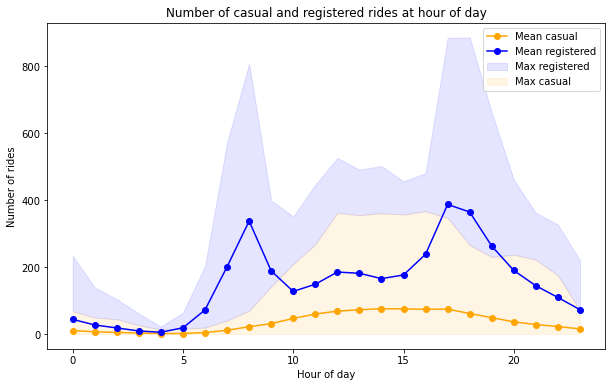

In [86]:
# your code here

casual_mean = bikes_df[['hour', 'casual']].groupby('hour').mean()
casual_max = bikes_df[['hour', 'casual']].groupby('hour').max()
registered_mean = bikes_df[['hour', 'registered']].groupby('hour').mean()
registered_max = bikes_df[['hour', 'registered']].groupby('hour').max()

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(
    registered_max.index,
    registered_max.registered,
    casual_max.casual,
    alpha=0.1,
    color='blue',
    label='Max registered'
)
ax.fill_between(
    casual_max.index,
    casual_max.casual,
    alpha=0.1,
    color='orange',
    label='Max casual'
)
ax.plot(
    casual_mean.index,
    casual_mean.casual,
    marker='o',
    color='orange',
    label='Mean casual'
)
ax.plot(
    registered_mean.index,
    registered_mean.registered,
    marker='o',
    color='blue',
    label='Mean registered'
)
ax.legend()
ax.set_title('Number of casual and registered rides at hour of day')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Number of rides')
plt.show()

<HR>
Both registered and casual curves share the same trend: rides begin in the morning, increase until afternoon, decreases at night and almost vanish at dawn. Despite this, registered rides have peaks in the beggining of the morning and at the end of afternoon. One hypothesis for this is because these are commuting time, that is, time of day where people are going to (or coming back from) work or school. Maybe it affects only registered rides because people who use bike to commute in general is registered: it's cheaper to ride bike everyday if you are registered.<HR>

#### 1.5 Use the variable holiday to show how holidays affect the relationship in question 1.4. What do you observe?

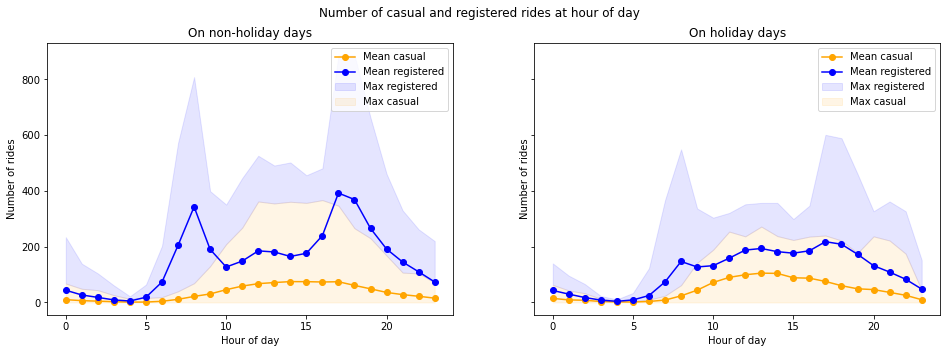

In [114]:
# your code here

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True, sharey=True)

for holiday in range(2):

    casual_mean = bikes_df[bikes_df.holiday == holiday][['hour', 'casual']].groupby('hour').mean()
    casual_max = bikes_df[bikes_df.holiday == holiday][['hour', 'casual']].groupby('hour').max()
    registered_mean = bikes_df[bikes_df.holiday == holiday][['hour', 'registered']].groupby('hour').mean()
    registered_max = bikes_df[bikes_df.holiday == holiday][['hour', 'registered']].groupby('hour').max()
    axes[holiday].fill_between(
        registered_max.index,
        registered_max.registered,
        casual_max.casual,
        alpha=0.1,
        color='blue',
        label='Max registered'
    )
    axes[holiday].fill_between(
        casual_max.index,
        casual_max.casual,
        alpha=0.1,
        color='orange',
        label='Max casual'
    )
    axes[holiday].plot(
        casual_mean.index,
        casual_mean.casual,
        marker='o',
        color='orange',
        label='Mean casual'
    )
    axes[holiday].plot(
        registered_mean.index,
        registered_mean.registered,
        marker='o',
        color='blue',
        label='Mean registered'
    )
    axes[holiday].legend()
    if not holiday:
        axes[0].set_title('On non-holiday days')
    else:
        axes[1].set_title('On holiday days')
    axes[holiday].set_xlabel('Hour of day')
    axes[holiday].set_ylabel('Number of rides')
    
fig.suptitle("Number of casual and registered rides at hour of day")
plt.show()

<HR>
    Both curves still share the same trends. However, it seems casual rides increase, maybe because recreation during holidays, and the peaks of registered rides decrease, most likely because less people is working during these days. We also see that in both curves there's a peak in max rides (the max number of rides at that hour of day) during the night (around 21:00), which doesn't appear on non-holiday days. It doesn't seem to affect the mean, maybe it's a specific day or set of days.<BR>
<HR>

#### 1.6  Use visualization to show how weather affects casual and registered rentals. What do you observe?

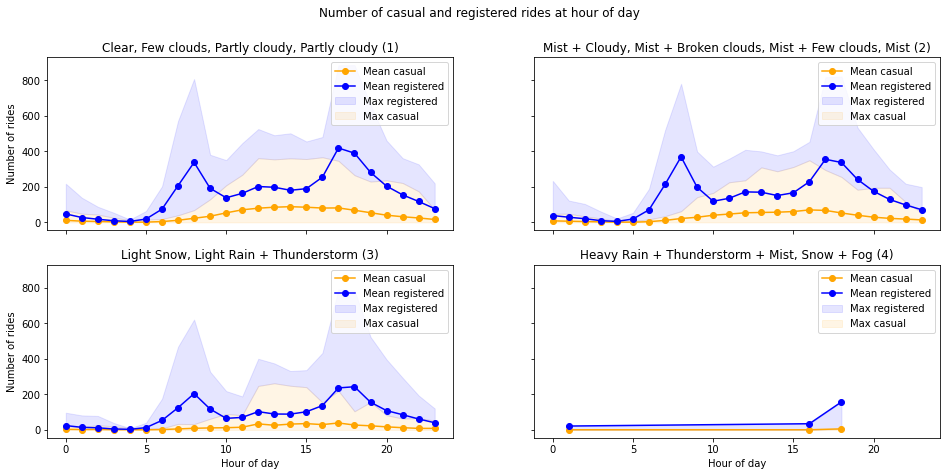

In [119]:
# your code here

fig, axes = plt.subplots(2, 2, figsize=(16, 7), sharex=True, sharey=True)

for weather in range(1, 5):    
    ax = axes.reshape(-1)[weather-1]

    casual_mean = bikes_df[bikes_df.weather == weather][['hour', 'casual']].groupby('hour').mean()
    casual_max = bikes_df[bikes_df.weather == weather][['hour', 'casual']].groupby('hour').max()
    registered_mean = bikes_df[bikes_df.weather == weather][['hour', 'registered']].groupby('hour').mean()
    registered_max = bikes_df[bikes_df.weather == weather][['hour', 'registered']].groupby('hour').max()
    ax.fill_between(
        registered_max.index,
        registered_max.registered,
        casual_max.casual,
        alpha=0.1,
        color='blue',
        label='Max registered'
    )
    ax.fill_between(
        casual_max.index,
        casual_max.casual,
        alpha=0.1,
        color='orange',
        label='Max casual'
    )
    ax.plot(
        casual_mean.index,
        casual_mean.casual,
        marker='o',
        color='orange',
        label='Mean casual'
    )
    ax.plot(
        registered_mean.index,
        registered_mean.registered,
        marker='o',
        color='blue',
        label='Mean registered'
    )
    ax.legend()
    
    if weather == 1:
        ax.set_title('Clear, Few clouds, Partly cloudy, Partly cloudy ({})'.format(weather))
    elif weather == 2:
        ax.set_title('Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ({})'.format(weather))
    elif weather == 3:
        ax.set_title('Light Snow, Light Rain + Thunderstorm ({})'.format(weather))
    elif weather == 4:
        ax.set_title('Heavy Rain + Thunderstorm + Mist, Snow + Fog ({})'.format(weather))

    if weather in [3, 4]:
        ax.set_xlabel('Hour of day')
    if weather in [1, 3]:
        ax.set_ylabel('Number of rides')
    
fig.suptitle("Number of casual and registered rides at hour of day")
plt.show()

<HR>
Let's compare the graphs with the first one (the one with clear sky or with clouds). It seems mist makes casual curve decreases, but it doesn't affect registered curve. Maybe it's because registered rides is most likely associated with people who needs the bike to get to work or home, and casual is most likely to be associated with recreation. Snow, rain and thunderstorm make both curves to decrease. But they still seem to share the same trend and peaks. For the graph 4, we don't have enough data. It's possibly because people doesn't ride bikes in adverse climate conditions, but we can't discard dataset problems too.
<HR>

<div class='exercise'> <b> Question 2: Explore Seasonality on Bike Ridership. </b></div>

#### Seasonality and weather

Now let's examine the effect of weather and time of the year. For example, you want to see how ridership varies with season of the year. 

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being **ONE** day:

- `dteday`, the timestamp for that day (fine to set to noon or any other time)
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals

Name this dataframe `bikes_by_day` and use it for all of Question 2.

**2.2** How does **season** affect the number of bike rentals for **casual riders** or **registered riders** per day? Use the variable `season` for this question. Comment on your observations. 

**2.3** What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

**2.4** How is the **distribution of total number of bike rentals** different for sunny days vs cloudy days?

**2.5** Visualize how the **total number of rides** per day varies with the **season**. Do you see any **outliers**? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. This is the same rule used by pyplot's boxplot function). If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.

#### HINT
- Use .copy() when creating the new dataframe, so you leave the original untouched. We will come back to it later.
- Use .groupby() to creat the new dataframe. You will have to make some choice on how to aggregate the variables.

### Answers

#### 2.1 Make a new dataframe with the following subset ...

In [ ]:
# your code here

#### 2.2 How does season affect the number of bike ...

In [ ]:
# your code here

<HR>
Your answer here
<HR>

#### 2.3 What percentage of rentals are made by casual riders or registered riders ...

In [ ]:
# your code here

<HR>
Your answer here
<HR>

#### 2.4 How is the distribution of total number of bike rentals different ...

In [ ]:
# your code here

<HR>
Your answer here
<HR>

#### 2.5 Visualize how the total number of rides per day ...

In [ ]:
# your code here

<HR>
Your answer here
<HR>

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

**3.1** Visualize and describe inter-dependencies among the following variables: `weekday`, `season`, `month`,`weather`, `temp`, `atemp`, `hum`, `windspeed`, `casual`,`registered`, `counts`. Note and comment on any strongly related variables.

**3.2** Convert the categorical attributes into multiple binary attributes using **one-hot encoding**. 


**3.3** Split the initial `bikes_df` dataset (with hourly data about rentals) into train and test sets. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. We ask you to create your train and test sets, but for consistency and easy checking we ask that, for the rest of this problem set, you use the train and test set provided in the question below.

**3.4** Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. After checking your train and test datasets for accuracy, remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis. Also, remove any predictors that would make predicting the `count` trivial.

**3.5** Calculate the **Pearson correlation** coefficients between all the features. Visualize the matrix using a heatmap. Which predictors have a positive correlation with the number of bike rentals? For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.

#### Hints: 
- You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.



#### Answers

#### 3.1 Visualize and describe inter-dependencies  ... 

In [ ]:
# your code here

<HR>
Your answer here
    <HR>

#### 3.2 Convert the categorical attributes  ....

In [ ]:
# your code here

<HR>
Your answer here
<HR>

#### 3.3 Split the initial bikes_df dataset...

In [ ]:
# your code here

#### 3.4  Read `data/BSS_train.csv` and `data/BSS_test.csv` into ...

In [ ]:
# your code here

<HR>
Your answer here
<HR>

#### 3.5 Calculate the **Pearson correlation** ....

In [ ]:
# your code here

<HR>
Your answer here
<HR>

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms), and report its $R^2$ score on the train and test sets.


**4.2** Find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value < 0.05). Comment on the results.


**4.3** Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is slightly different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms? 

### Answers
#### 4.1 Use statsmodels to fit a ... 


In [ ]:
# your code here

<HR>
Your answer here
<HR>

#### 4.2 Find out which of estimated coefficients ...

In [ ]:
# your code here

<HR>
Your answer here<BR>
<HR>

#### 4.3 Make a plot of residuals of the fitted ...

In [ ]:
# your code here

<div class='exercise'> <b>Question 5: Subset Selection </b> </div>

**5.1** Implement forward step-wise  selection to select a minimal subset of predictors that are related to the response variable: 

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. 

**5.2** Do these methods eliminate one or more of the colinear predictors (if any) identified in Question 3.5?  If so, which ones. Briefly explain (3 or fewer sentences) why you think this may be the case.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Question 4 using all predictors?

### Answers

#### 5.1  Implement forward step-wise ....

In [ ]:
# your code here

<HR>
Your answer here
<HR>

#### 5.2 Do these methods eliminate ...

<HR>
Your answer here
<HR>

#### 5.3 In each case, fit linear regression  ...

In [ ]:
# your code here

<HR>
Your answer here
<HR>

<div class='exercise'> <b> Question 6: Polynomial Regression </b> </div> 

We will now try to improve the performance of the regression model by including higher-order polynomial terms. 

**6.1** For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a polynomial regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in the previous question? Using a $t$-tests, find out which of the estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

In [ ]:
# your code here

<HR>
Your answer here
<HR>

#  Written Report to the Administrators
<br>

<div class='exercise'> <b> Question 7 </b> </div>

Write a short summary report, intended for the administrators of the company, to address two major points (can be written as two large paragraphs):

1. How to predict ridership well (which variables are important, when is ridership highest/lowest, etc.).

2. Suggestions on how to increase the system revenue (what additional services to provide, when to give discounts, etc.).
 
Include your report below. The report should not be longer than 300 words and should include a maximum of 3 figures. 

### Answers
#### 7
<HR>
Your report here
<HR>

